let’s extend our BATMAN-based synthetic light curve into a full fitting routine so you can recover the planet radius (rp) from noisy data, just like astronomers do with Kepler/TESS.

***Module 3b — Fitting Exoplanet Radius with batman***

In [1]:
import batman
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# -----------------
# Step 1: Define True Transit Parameters
# -----------------
true_params = {
    "t0": 0.0,         # mid-transit time [days]
    "per": 1.0,        # orbital period [days]
    "rp": 0.1,         # planet radius (in stellar radii)
    "a": 15.0,         # semi-major axis (in stellar radii)
    "inc": 87.0,       # inclination [deg]
    "ecc": 0.0,        # eccentricity
    "w": 90.0,         # longitude of periastron
    "limb_dark": "quadratic", # limb darkening law
    "u": [0.1, 0.3]    # limb darkening coefficients
}


In [2]:
# Create parameter object
m_true = batman.TransitParams()
for k, v in true_params.items():
    setattr(m_true, k, v)

# Time grid
t = np.linspace(-0.05, 0.05, 500)

# Generate synthetic true flux
model_true = batman.TransitModel(m_true, t)
flux_true = model_true.light_curve(m_true)

# Add Gaussian noise
rng = np.random.default_rng(42)
flux_obs = flux_true + rng.normal(0, 0.0005, size=len(flux_true))

In [3]:
# -----------------
# Step 2: Define fitting model (only vary rp)
# -----------------
def transit_model_fit(t, rp):
    m = batman.TransitParams()
    for k, v in true_params.items():
        setattr(m, k, v)
    m.rp = rp
    model = batman.TransitModel(m, t)
    return model.light_curve(m)

In [4]:
# -----------------
# Step 3: Fit planet radius
# -----------------
popt, pcov = curve_fit(transit_model_fit, t, flux_obs, p0=[0.12], bounds=(0.01, 0.5))
rp_fit = popt[0]
rp_err = np.sqrt(np.diag(pcov))[0]

print(f"True Rp/Rs = {true_params['rp']:.3f}")
print(f"Fit Rp/Rs  = {rp_fit:.3f} ± {rp_err:.3f}")


True Rp/Rs = 0.100
Fit Rp/Rs  = 0.100 ± 0.000


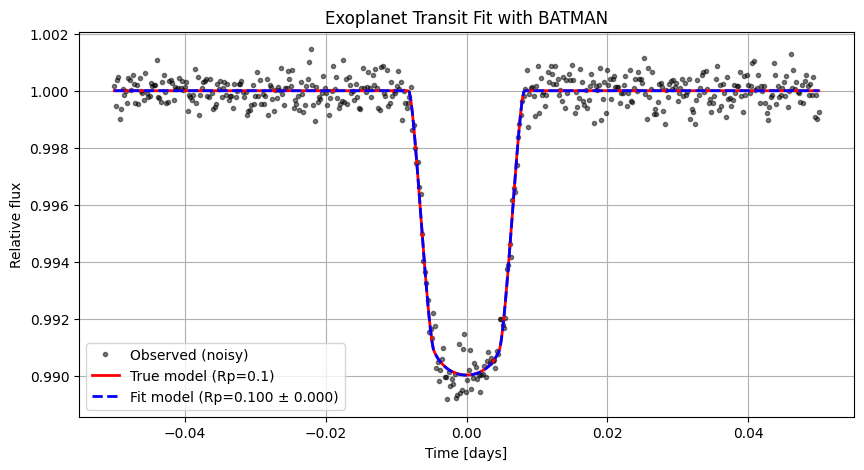

In [5]:
# -----------------
# Step 4: Plot results
# -----------------
plt.figure(figsize=(10,5))
plt.plot(t, flux_obs, 'k.', alpha=0.5, label="Observed (noisy)")
plt.plot(t, flux_true, 'r-', lw=2, label=f"True model (Rp={true_params['rp']})")
plt.plot(t, transit_model_fit(t, rp_fit), 'b--', lw=2,
         label=f"Fit model (Rp={rp_fit:.3f} ± {rp_err:.3f})")

plt.xlabel("Time [days]")
plt.ylabel("Relative flux")
plt.title("Exoplanet Transit Fit with BATMAN")
plt.legend()
plt.grid(True)
plt.show()